In [ ]:
from google.colab import drive
from google.colab import files 


drive.mount("/content/gdrive")
print(os.getcwd())
os.chdir("/content/gdrive/My Drive/AML2021")
print(os.getcwd())

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os

import tensorflow as tf

from tensorflow.keras import backend, optimizers, models, applications, metrics
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
import tensorflow.keras.utils as utils

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

print(x_train.shape, y_train.shape)

(16324, 299, 299, 3) (16324, 2)


In [4]:
# Adapt Constants
date = time.strftime("%d-%m-%Y_%H-%M-%S")
MODEL_NAME = f"EfficientNet-NoPretraining-{date}"
os.makedirs(f'models/{MODEL_NAME}', exist_ok = True) 
INPUT_SHAPE = (299, 299, 3)
NUM_CLASSES = 2
INITIAL_EPOCH = 0
NUM_EPOCHS = 120
OPTIMIZER = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
BATCH_SIZE = 16

LRS = ReduceLROnPlateau(monitor='val_auroc', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001)
ES = EarlyStopping(monitor='val_auroc', min_delta=0.0001, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


MC = ModelCheckpoint(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq="epoch")
MC_BEST = ModelCheckpoint(f'models/{MODEL_NAME}/best-{MODEL_NAME}.hdf5', monitor='val_auroc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
LOG = CSVLogger(f'models/{MODEL_NAME}/{MODEL_NAME}.log')
TB = TensorBoard(log_dir=f'models/{MODEL_NAME}/logs')

METRICS = [metrics.AUC(name='auroc', curve='ROC'),
           metrics.CategoricalAccuracy(name='accuracy'),
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall')
           ]

# Load data
assert(backend.image_data_format()=='channels_last')

# Model: preprocess, base model, top layer/classifier
i = Input(shape=INPUT_SHAPE)
x = applications.efficientnet.preprocess_input(i)


base_model = applications.efficientnet.EfficientNetB3(include_top=False, weights=None, input_shape=INPUT_SHAPE)
x = base_model(x)

x = GlobalAveragePooling2D(name='avg_pool')(x)
o = Dense(NUM_CLASSES, activation='softmax', name=f'fc{NUM_CLASSES}')(x)

model = models.Model(inputs=i, outputs=o)

# Train Model
if INITIAL_EPOCH != 0:
	model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
else:
  model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=METRICS)

model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, validation_split = 0.2, callbacks = [MC, MC_BEST, LRS, ES, LOG, TB], epochs = NUM_EPOCHS, initial_epoch = INITIAL_EPOCH)

Epoch 1/120
817/817 [==============================] - 542s 644ms/step - loss: 1.0226 - auroc: 0.5955 - accuracy: 0.5802 - precision: 0.5802 - recall: 0.5802 - val_loss: 0.6706 - val_auroc: 0.6417 - val_accuracy: 0.5985 - val_precision: 0.5985 - val_recall: 0.5985

Epoch 00001: saving model to models/EfficientNet-NoPretraining-21-09-2021_19-23-25\latest-EfficientNet-NoPretraining-21-09-2021_19-23-25.hdf5

Epoch 00001: val_auroc improved from inf to 0.64169, saving model to models/EfficientNet-NoPretraining-21-09-2021_19-23-25\best-EfficientNet-NoPretraining-21-09-2021_19-23-25.hdf5
Epoch 2/120
817/817 [==============================] - 521s 637ms/step - loss: 0.5820 - auroc: 0.7633 - accuracy: 0.6967 - precision: 0.6967 - recall: 0.6967 - val_loss: 0.4579 - val_auroc: 0.8795 - val_accuracy: 0.7960 - val_precision: 0.7960 - val_recall: 0.7960

Epoch 00002: saving model to models/EfficientNet-NoPretraining-21-09-2021_19-23-25\latest-EfficientNet-NoPretraining-21-09-2021_19-23-25.hdf5

Ep

In [5]:
# Eval Model
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

model = models.load_model(f'models/{MODEL_NAME}/latest-{MODEL_NAME}.hdf5', compile=True)
out = model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, verbose=1)

# Save Results
with open("results.txt","a+") as f:
  f.write(f"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n")
print(f"wrote \"{MODEL_NAME} test_loss: {out[0]}, test_auroc: {out[1]}, test_acc: {out[2]}, test_prec: {out[3]}, test_rec: {out[4]}, test_f1: {2* ((out[3]*out[4]) / (out[3]+out[4]))}\n\" to results.txt ")

173/173 [==============================] - 23s 123ms/step - loss: 0.0671 - auroc: 0.9960 - accuracy: 0.9815 - precision: 0.9815 - recall: 0.9815
wrote "EfficientNet-NoPretraining-21-09-2021_19-23-25 test_loss: 0.06711085140705109, test_auroc: 0.9959845542907715, test_acc: 0.9815418124198914, test_prec: 0.9815418124198914, test_rec: 0.9815418124198914, test_f1: 0.9815418124198914
" to results.txt 


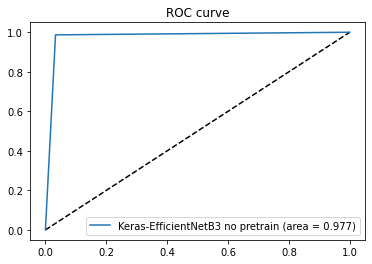

In [7]:
#Plot ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras-EfficientNetB3 no pretrain (area = {:.3f})'.format(auc))
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()